# Question B3 (10 marks)

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
!pip install captum

You should consider upgrading via the 'c:\users\joann\coding projects\ipynb dump\ipynb-dump\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

1.First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [3]:
df = pd.read_csv('hdb_price_prediction.csv')

train_df = df[df['year'] <= 2019] 
validation_df = df[df['year'] == 2020] 
test_df = df[df['year'] == 2021]

numeric_features = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']

X_train, y_train = train_df[numeric_features], train_df["resale_price"]
X_valid, y_valid = validation_df[numeric_features], validation_df["resale_price"]
X_test, y_test = test_df[numeric_features], test_df["resale_price"]

2.Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [4]:
no_hidden = 5  
no_output = 1
no_features = len(numeric_features)

lr = 0.001  
epochs = 100  
batch_size = 64

class PartBModel(nn.Module):
    def __init__(self, no_features, no_hidden, no_output):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(no_features, no_hidden),  
            nn.ReLU(),  
            
            nn.Linear(no_hidden, no_hidden),  
            nn.ReLU(),  
            
            nn.Linear(no_hidden, no_hidden),  
            nn.ReLU(),  
            
            nn.Linear(no_hidden, no_output)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
from common_utils import train_loop, test_loop, CustomDataset
from torch.utils.data import DataLoader

model_not_scaled = PartBModel(no_features, no_hidden, no_output)
optimizer = torch.optim.Adam(model_not_scaled.parameters(), lr = lr)
loss_fn = nn.MSELoss()

train_data = CustomDataset(X_train.to_numpy(), y_train.to_numpy())
test_data = CustomDataset(X_test.to_numpy(), y_test.to_numpy())

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

tr_loss = []
te_loss = []
for t in range(epochs):
    train_loss, _ = train_loop(train_dataloader, model_not_scaled,loss_fn, optimizer)
    test_loss, _ = test_loop(test_dataloader, model_not_scaled, loss_fn)

    tr_loss.append(train_loss)
    te_loss.append(test_loss)

    print(f"Epoch {t+1}: Train_loss: {train_loss:>8f}, Test_loss: {test_loss:>8f}")


Epoch 1: Train_loss: 206970043826.765228, Test_loss: 235634253013.802185
Epoch 2: Train_loss: 80296660335.760239, Test_loss: 32138394450.707691
Epoch 3: Train_loss: 15914473745.646353, Test_loss: 20927071462.083515
Epoch 4: Train_loss: 15247996102.457542, Test_loss: 20293753519.542858
Epoch 5: Train_loss: 14814913121.182817, Test_loss: 20541204813.081318
Epoch 6: Train_loss: 14331223496.247753, Test_loss: 19499044224.843956
Epoch 7: Train_loss: 13830611917.362637, Test_loss: 18679740479.859341
Epoch 8: Train_loss: 13324269302.025974, Test_loss: 18136222208.562637
Epoch 9: Train_loss: 12811802677.706293, Test_loss: 17736653805.995605
Epoch 10: Train_loss: 12293347387.844156, Test_loss: 16870048553.072527
Epoch 11: Train_loss: 11757660289.918081, Test_loss: 16700396122.725275
Epoch 12: Train_loss: 11204425688.615385, Test_loss: 16000231014.400000
Epoch 13: Train_loss: 10619538165.770229, Test_loss: 15709803372.532967
Epoch 14: Train_loss: 9995352876.243755, Test_loss: 15026574852.571428


In [6]:
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float)
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float)

#Gradient Shap (Unscaled)
gradient_shap = GradientShap(model_not_scaled)
gradient_shap_attr, delta = gradient_shap.attribute(X_test_tensor[:1000], X_train_tensor, return_convergence_delta=True)
gradient_shap_test_sum = gradient_shap_attr.detach().numpy().sum(0)
gradient_shap_test_norm_sum = gradient_shap_test_sum / np.linalg.norm(gradient_shap_test_sum, ord=1)

# Saliency (Unscaled)
saliency = Saliency(model_not_scaled)
saliency_test = saliency.attribute(X_test_tensor[:1000])
saliency_test_sum = saliency_test.detach().numpy().sum(0)
saliency_test_norm_sum = saliency_test_sum / np.linalg.norm(saliency_test_sum, ord=1)

# Input x Gradients (Unscaled)
input_x_gradient = InputXGradient(model_not_scaled)
input_x_gradient_test = input_x_gradient.attribute(X_test_tensor[:1000])
input_x_gradient_test_sum = input_x_gradient_test.detach().numpy().sum(0)
input_x_gradient_test_norm_sum = input_x_gradient_test_sum / np.linalg.norm(input_x_gradient_test_sum, ord=1)

# Integrated Gradients (Unscaled)
integrated_gradients = IntegratedGradients(model_not_scaled)
integrated_gradients_test = integrated_gradients.attribute(X_test_tensor[:1000])
integrated_gradients_test_sum = integrated_gradients_test.detach().numpy().sum(0)
integrated_gradients_test_norm_sum = integrated_gradients_test_sum / np.linalg.norm(integrated_gradients_test_sum, ord=1)

# Feature Ablation (Unscaled)
feature_ablation = FeatureAblation(model_not_scaled)
feature_ablation_test = feature_ablation.attribute(X_test_tensor[:1000])
feature_ablation_test_sum = feature_ablation_test.detach().numpy().sum(0)
feature_ablation_test_norm_sum = feature_ablation_test_sum / np.linalg.norm(feature_ablation_test_sum, ord=1)

df_unscaled = pd.DataFrame({
    'Features': numeric_features,
    'Gradient Shap (Unscaled)': gradient_shap_test_norm_sum,
    'Saliency (Unscaled)': saliency_test_norm_sum,
    'Input x Gradients (Unscaled)': input_x_gradient_test_norm_sum,
    'Integrated Gradients (Unscaled)': integrated_gradients_test_norm_sum,
    "Feature Ablation (Unscaled)" : feature_ablation_test_norm_sum
})

display(df_unscaled)

c:\Users\joann\Coding Projects\ipynb dump\ipynb-dump\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


,Features,Gradient Shap (Unscaled),Saliency (Unscaled),Input x Gradients (Unscaled),Integrated Gradients (Unscaled),Feature Ablation (Unscaled)
0,dist_to_nearest_stn,0.010542,0.412226,-0.057716,-0.057472,-0.058289
1,dist_to_dhoby,0.369188,0.134000,-0.192149,-0.191754,-0.194057
2,degree_centrality,-0.000178,0.313016,0.000945,0.000943,0.000955
3,eigenvector_centrality,-0.000111,0.084179,0.000081,0.000081,0.000082
4,remaining_lease_years,-0.317637,0.028112,0.310461,0.310331,0.312651
5,floor_area_sqm,-0.302344,0.028467,0.438648,0.439419,0.433966


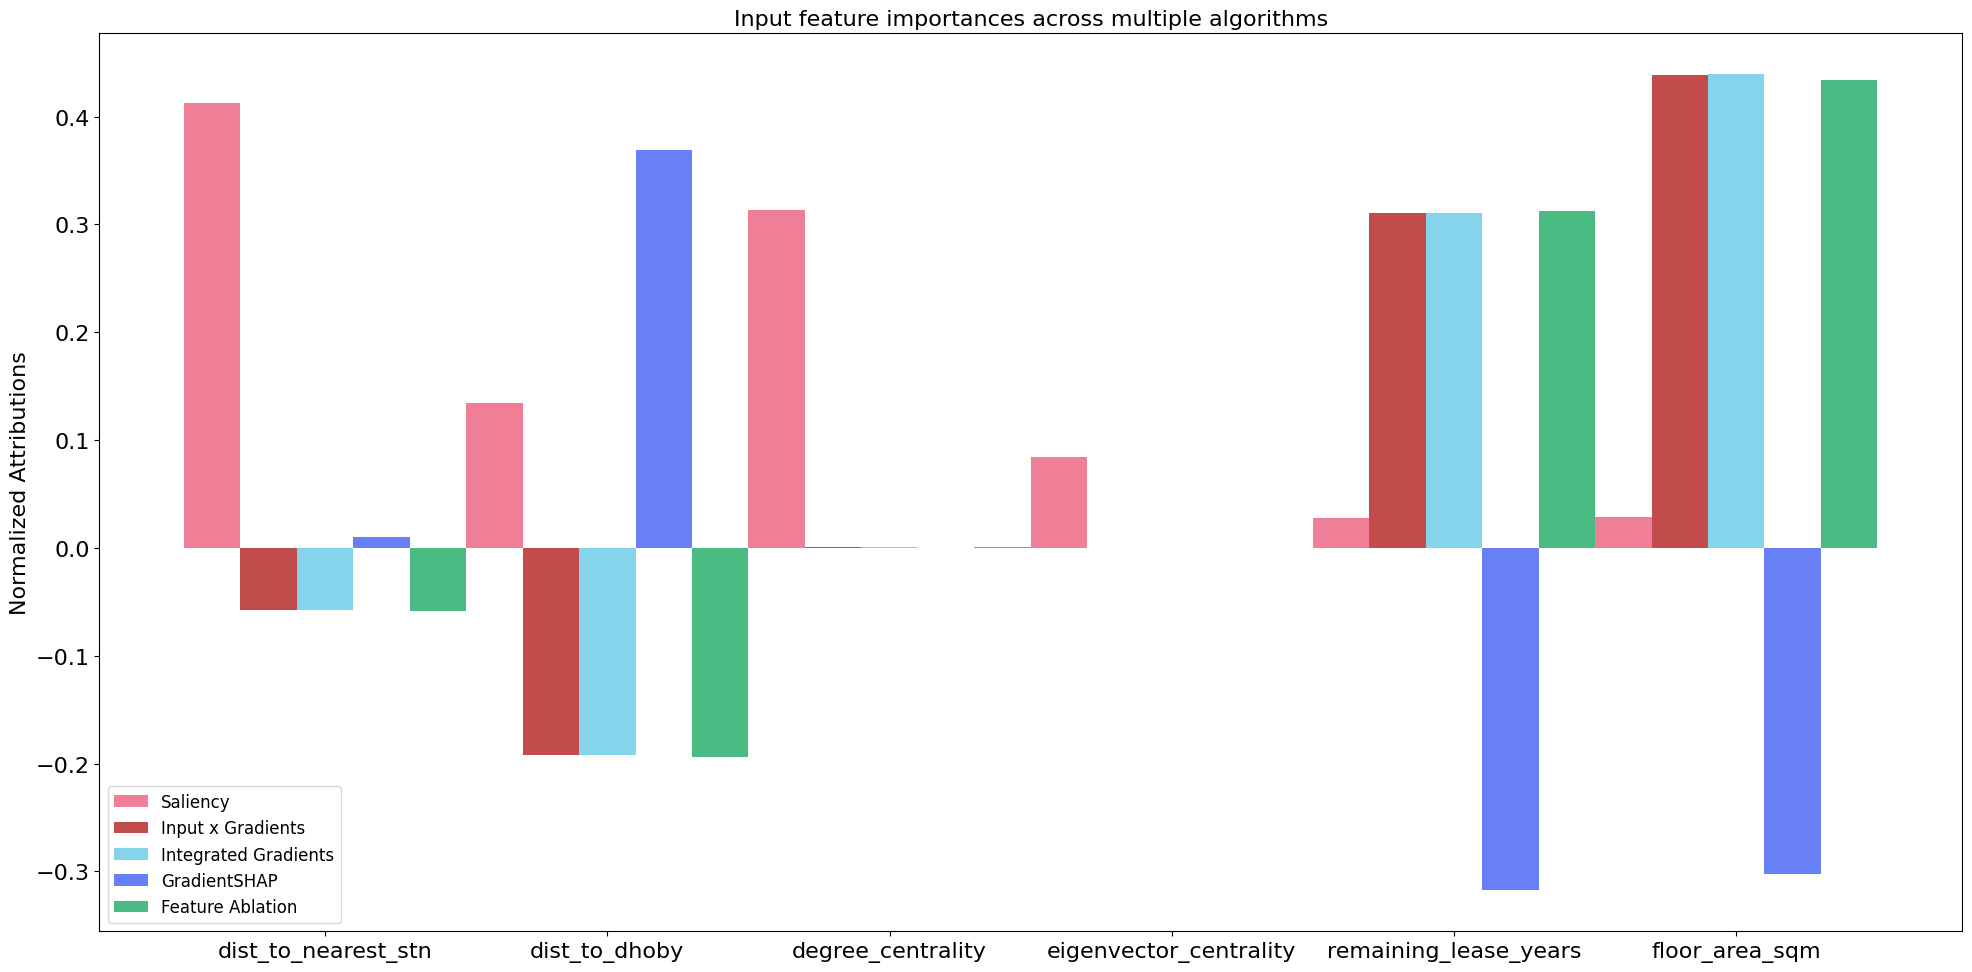

In [18]:
# Plot settings
import matplotlib.pyplot as plt
width = 0.20
legends = ['Saliency', 'Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))
ax = plt.subplot()

ax.set_title('Input feature importances across multiple algorithms')
ax.set_ylabel('Normalized Attributions')

# Plotting
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: numeric_features[idx], x_axis_data))

ax.bar(x_axis_data, saliency_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, input_x_gradient_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, integrated_gradients_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gradient_shap_test_norm_sum, width, align='center', alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, feature_ablation_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 2 * width)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

3.Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [8]:
from common_utils import train_loop, test_loop, CustomDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler


model_scaled = PartBModel(no_features, no_hidden, no_output)
optimizer = torch.optim.Adam(model_not_scaled.parameters(), lr = lr)
loss_fn = nn.MSELoss()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_data = CustomDataset(X_train_scaled, y_train.to_numpy())
test_data = CustomDataset(X_test_scaled, y_test.to_numpy())

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

tr_loss_scaled = []
te_loss_scaled = []
for t in range(epochs):
    train_loss, _ = train_loop(train_dataloader, model_scaled,loss_fn, optimizer)
    test_loss, _ = test_loop(test_dataloader, model_scaled, loss_fn)

    tr_loss_scaled.append(train_loss)
    te_loss_scaled.append(test_loss)

    print(f"Epoch {t+1}: Train_loss: {train_loss:>8f}, Test_loss: {test_loss:>8f}")


Epoch 1: Train_loss: 216351024257.918091, Test_loss: 288019311514.725281
Epoch 2: Train_loss: 216352325239.176819, Test_loss: 287917574508.588989
Epoch 3: Train_loss: 216355420931.324677, Test_loss: 288124712919.490112
Epoch 4: Train_loss: 216355821283.612396, Test_loss: 288290771817.213196
Epoch 5: Train_loss: 216352861442.813202, Test_loss: 289168272786.848328
Epoch 6: Train_loss: 216358338887.352661, Test_loss: 287717690464.773621
Epoch 7: Train_loss: 216351694217.846161, Test_loss: 287574025866.408813
Epoch 8: Train_loss: 216353401558.313690, Test_loss: 288461173303.138489
Epoch 9: Train_loss: 216350405888.767242, Test_loss: 287520717731.727478
Epoch 10: Train_loss: 216353325907.116882, Test_loss: 288377094035.973633
Epoch 11: Train_loss: 216353315857.390594, Test_loss: 287919740689.441772
Epoch 12: Train_loss: 216354424289.822174, Test_loss: 287758343381.802185
Epoch 13: Train_loss: 216356241768.087921, Test_loss: 287581944289.617554
Epoch 14: Train_loss: 216354619637.514496, Test

In [9]:
#TODO: Check res orng gmna

X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float)

#Gradient Shap (Scaled)
gradient_shap_scaled = GradientShap(model_scaled)
gradient_shap_attr_scaled, delta_scaled = gradient_shap_scaled.attribute(X_test_scaled_tensor[:1000], X_train_scaled_tensor, return_convergence_delta=True)
gradient_shap_test_scaled_sum = gradient_shap_attr_scaled.detach().numpy().sum(0)
gradient_shap_test_scaled_norm_sum = gradient_shap_test_scaled_sum / np.linalg.norm(gradient_shap_test_scaled_sum, ord=1)

df_gradientSHAP = pd.DataFrame({
    'Features': numeric_features,
    'GradientShap (Not Scaled) Normalized': gradient_shap_test_norm_sum,
    'GradientShap (Scaled) Normalized': gradient_shap_test_scaled_norm_sum,
})

df_gradientSHAP_convergence = pd.DataFrame({
    'Features': ["Convergence Values"],
    'GradientShap (Not Scaled)': [np.mean(delta.detach().numpy())],
    'GradientShap (Scaled)': [np.mean(delta_scaled.detach().numpy())],
})

display(df_gradientSHAP)

,Features,GradientShap (Not Scaled) Normalized,GradientShap (Scaled) Normalized
0,dist_to_nearest_stn,0.010542,0.002237
1,dist_to_dhoby,0.369188,0.509899
2,degree_centrality,-0.000178,0.192633
3,eigenvector_centrality,-0.000111,0.016950
4,remaining_lease_years,-0.317637,-0.114158
5,floor_area_sqm,-0.302344,-0.164124


## GradientShap

### Feature Attributions
- After scaling, the attributions for all six features—**dist_to_nearest_stn**, **dist_to_dhoby**, **degree_centrality**, **eigenvector_centrality**, **remaining_lease_years**, and **floor_area_sqm**—exhibit significant variations.
  
  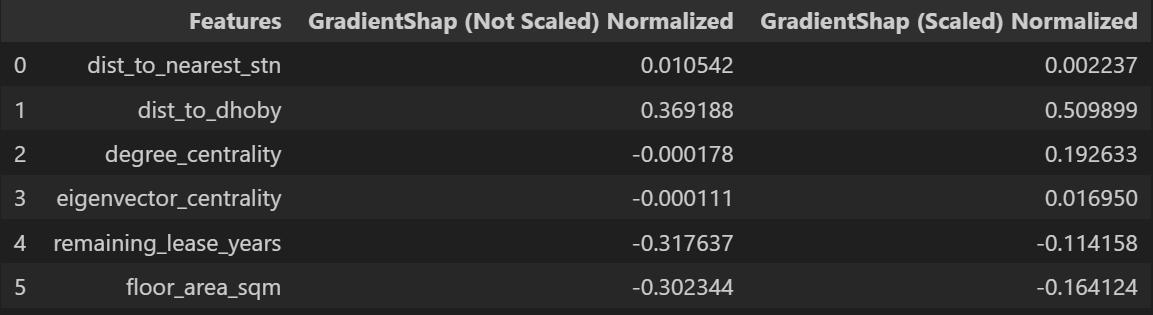
  
- **Reasons for Variations:**
  1. GradientSHAP calculations depend on a selected baseline. Unscaled inputs used an **unscaled baseline**, while scaled inputs utilized a **scaled baseline**.



  2. GradientSHAP introduces Gaussian noise, leading to potential variations in attributions, especially when data scaling changes.


In [10]:
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float)

# Saliency (Scaled)
saliency = Saliency(model_scaled)
saliency_test_scaled = saliency.attribute(X_test_scaled_tensor[:1000])
saliency_test_sum_scaled = saliency_test_scaled.detach().numpy().sum(0)
saliency_test_norm_sum_scaled = saliency_test_sum_scaled / np.linalg.norm(saliency_test_sum_scaled, ord=1)

# Input x Gradients (Scaled)
input_x_gradient = InputXGradient(model_scaled)
input_x_gradient_test_scaled = input_x_gradient.attribute(X_test_scaled_tensor[:1000])
input_x_gradient_test_sum_scaled = input_x_gradient_test_scaled.detach().numpy().sum(0)
input_x_gradient_test_norm_sum_scaled = input_x_gradient_test_sum_scaled / np.linalg.norm(input_x_gradient_test_sum_scaled, ord=1)

# Integrated Gradients (Scaled)
integrated_gradients = IntegratedGradients(model_scaled)
integrated_gradients_test_scaled = integrated_gradients.attribute(X_test_scaled_tensor[:1000])
integrated_gradients_test_sum_scaled = integrated_gradients_test_scaled.detach().numpy().sum(0)
integrated_gradients_test_norm_sum_scaled = integrated_gradients_test_sum_scaled / np.linalg.norm(integrated_gradients_test_sum_scaled, ord=1)

# Feature Ablation (Scaled)
feature_ablation = FeatureAblation(model_scaled)
feature_ablation_test_scaled = feature_ablation.attribute(X_test_scaled_tensor[:1000])
feature_ablation_test_sum_scaled = feature_ablation_test_scaled.detach().numpy().sum(0)
feature_ablation_test_norm_sum_scaled = feature_ablation_test_sum_scaled / np.linalg.norm(feature_ablation_test_sum_scaled, ord=1)


c:\Users\joann\Coding Projects\ipynb dump\ipynb-dump\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

4.Why did Saliency produce scores similar to IG?


In [11]:
# YOUR ANSWER HERE
#TODO: Check jwban orng gmna
"""
## Overview of Saliency and Integrated Gradients

Both **Saliency** and **Integrated Gradients (IG)** are methods that rely on gradients for model interpretation. Here's a brief comparison:

- **Saliency**:
  - Measures the gradient of the model's output concerning input features.
  - Reveals how variations in the input influence the model's predictions.

- **Integrated Gradients (IG)**:
  - Aggregates gradients along a path from a baseline input to the actual input.
  - Provides a more detailed perspective on the significance of each feature.



<br>

When the relationship between input features and output predictions is predominantly **linear**, both Saliency and IG can yield **comparable results** due to:

- Saliency effectively capturing the **local gradient**.
- If the local gradient remains relatively constant along the path to the baseline, IG averages those similar values, leading to similar feature attributions.

In our specific case of predicting **HDB resale prices**, the regression problem involves:


- A **complex interplay** among various input features.
- Likely **non-linear** relationships, meaning that local gradients may not adequately represent the overall relationships.

<br>

As a result, **Saliency** does not yield scores that align closely with those from **IG** in this context.




- **Normalizing the features** does not mitigate the disparity between Saliency and IG because:
  - The difference stems from the fundamental characteristics of each method.
  - Saliency's point attribution may overlook broader non-linear trends.
  - IG’s path evaluation captures intricate non-linear relationships, particularly in features like **degree_centrality**.
"""

"\n## Overview of Saliency and Integrated Gradients\n\nBoth **Saliency** and **Integrated Gradients (IG)** are methods that rely on gradients for model interpretation. Here's a brief comparison:\n\n- **Saliency**:\n  - Measures the gradient of the model's output concerning input features.\n  - Reveals how variations in the input influence the model's predictions.\n\n- **Integrated Gradients (IG)**:\n  - Aggregates gradients along a path from a baseline input to the actual input.\n  - Provides a more detailed perspective on the significance of each feature.\n\n\n\n<br>\n\nWhen the relationship between input features and output predictions is predominantly **linear**, both Saliency and IG can yield **comparable results** due to:\n\n- Saliency effectively capturing the **local gradient**.\n- If the local gradient remains relatively constant along the path to the baseline, IG averages those similar values, leading to similar feature attributions.\n\nIn our specific case of predicting **HDB

In [12]:
compare1 = pd.DataFrame({
    'Features': numeric_features,
    'Saliency (Unscaled)': saliency_test_norm_sum,
    'Integrated Gradients (Unscaled)': integrated_gradients_test_norm_sum,

    'Saliency (Scaled)': saliency_test_norm_sum_scaled,
    'Integrated Gradients (Scaled)': integrated_gradients_test_norm_sum_scaled,
})

display(compare1)

,Features,Saliency (Unscaled),Integrated Gradients (Unscaled),Saliency (Scaled),Integrated Gradients (Scaled)
0,dist_to_nearest_stn,0.412226,-0.057472,0.150137,-0.010771
1,dist_to_dhoby,0.134000,-0.191754,0.287015,0.437001
2,degree_centrality,0.313016,0.000943,0.287570,0.089558
3,eigenvector_centrality,0.084179,0.000081,0.046040,-0.004747
4,remaining_lease_years,0.028112,0.310331,0.040425,-0.105721
5,floor_area_sqm,0.028467,0.439419,0.188812,-0.352202


## Overview of Saliency and Integrated Gradients

Both **Saliency** and **Integrated Gradients (IG)** are methods that rely on gradients for model interpretation.
- **Saliency**:
  - Measures the gradient of the model's output concerning input features.
  - Reveals how variations in the input influence the model's predictions.

- **Integrated Gradients (IG)**:
  - Aggregates gradients along a path from a baseline input to the actual input.
  - Provides a more detailed perspective on the significance of each feature.



<br>

When the relationship between input features and output predictions is predominantly **linear**, both Saliency and IG can yield **comparable results** due to:

- Saliency effectively capturing the **local gradient**.
- If the local gradient remains relatively constant along the path to the baseline, IG averages those similar values, leading to similar feature attributions.

In our specific case of predicting **HDB resale prices**, the regression problem involves:


- A **complex interplay** among various input features.
- Likely **non-linear** relationships, meaning that local gradients may not adequately represent the overall relationships.

<br>

As a result, **Saliency** does not yield scores that align closely with those from **IG** in this context.




- **Normalizing the features** does not mitigate the disparity between Saliency and IG because:
  - The difference stems from the fundamental characteristics of each method.
  - Saliency's point attribution may overlook broader non-linear trends.
  - IG’s path evaluation captures intricate non-linear relationships, particularly in features like **degree_centrality**.



5.Why did Input x Gradients give the same attribution scores as IG?


In [13]:
# YOUR ANSWER HERE
#TODO: Check jwban orng gmna

"""
In classification tasks, neural networks often encounter the **saturation problem**. This occurs when certain neurons activate strongly for specific classes, resulting in gradients that are **near zero**. The implications of saturation include:

- **Obscured feature contributions:** It becomes challenging to interpret the model's decision based on direct gradients, as done in **Input × Gradient (IxG)**.

**Integrated Gradients (IG)** addresses the saturation issue by:

- Integrating gradients along a path from a baseline to the actual input.
- Capturing gradient information across a range of inputs, which potentially mitigates the saturation effect.

## Differences in Regression Tasks

In contrast, regression tasks present a continuous output space where:

- **Predictions are not constrained** to discrete classes.
- The continuous nature of outputs reduces the likelihood of saturation compared to classification tasks.

### Implications for Gradients:

- **Informative Gradients:** In regression contexts, the gradients of the output with respect to the input can remain informative and are **less prone to saturation** effects.
- **Path Integral Similarity:** The difference between computing the path integral of gradients (IG) and directly using gradients (IxG) might not be significant, as:

  - The continuous output space allows for **more gradual changes** in predictions.
  - Direct gradients serve as a reliable indicator of feature importance, similar to the integrated path of gradients in IG.

## Similarities and Differences in Data

### Unscaled Data

- **Similarity:** Unscaled data from IG and IxG is very similar in value 
  - This similarity arises because both methods utilize the output gradient multiplied by the input values, with IG merely integrating the gradient. This overlap occurs due to their shared concepts regarding input features.


### Scaled Data

- **Significant Differences:** When scaling is applied, notable differences can be observed between IG and IxG data:
  - This is because scaling can greatly influence how gradients are calculated. Input gradients may exhibit clearer variations since the model's response to scaled inputs can differ, leading to gradients that more accurately reflect this sensitivity.
"""

"\nIn classification tasks, neural networks often encounter the **saturation problem**. This occurs when certain neurons activate strongly for specific classes, resulting in gradients that are **near zero**. The implications of saturation include:\n\n- **Obscured feature contributions:** It becomes challenging to interpret the model's decision based on direct gradients, as done in **Input × Gradient (IxG)**.\n\n**Integrated Gradients (IG)** addresses the saturation issue by:\n\n- Integrating gradients along a path from a baseline to the actual input.\n- Capturing gradient information across a range of inputs, which potentially mitigates the saturation effect.\n\n## Differences in Regression Tasks\n\nIn contrast, regression tasks present a continuous output space where:\n\n- **Predictions are not constrained** to discrete classes.\n- The continuous nature of outputs reduces the likelihood of saturation compared to classification tasks.\n\n### Implications for Gradients:\n\n- **Informati

In [14]:
compare2 = pd.DataFrame({
    'Features': numeric_features,
    'Input x Gradients (Unscaled)': input_x_gradient_test_norm_sum,
    'Integrated Gradients (Unscaled)': integrated_gradients_test_norm_sum,

    'Input x Gradients (Scaled)': input_x_gradient_test_norm_sum_scaled,
    'Integrated Gradients (Scaled)': integrated_gradients_test_norm_sum_scaled,
})

display(compare2)

,Features,Input x Gradients (Unscaled),Integrated Gradients (Unscaled),Input x Gradients (Scaled),Integrated Gradients (Scaled)
0,dist_to_nearest_stn,-0.057716,-0.057472,-0.014491,-0.010771
1,dist_to_dhoby,-0.192149,-0.191754,0.393716,0.437001
2,degree_centrality,0.000945,0.000943,0.080243,0.089558
3,eigenvector_centrality,0.000081,0.000081,-0.006735,-0.004747
4,remaining_lease_years,0.310461,0.310331,-0.096217,-0.105721
5,floor_area_sqm,0.438648,0.439419,-0.408598,-0.352202


In classification tasks, neural networks often encounter the **saturation problem**. This occurs when certain neurons activate strongly for specific classes, resulting in gradients that are **near zero**. The implications of saturation include:

- **Obscured feature contributions:** It becomes challenging to interpret the model's decision based on direct gradients, as done in **Input × Gradient (IxG)**

**Integrated Gradients (IG)** addresses the saturation issue by:

- Integrating gradients along a path from a baseline to the actual input
- Capturing gradient information across a range of inputs, which potentially mitigates the saturation effect

## Differences in Regression Tasks

In contrast, regression tasks present a continuous output space where:

- **Predictions are not constrained** to discrete classes
- The continuous nature of outputs reduces the likelihood of saturation compared to classification tasks

Therefore, in regression contexts, the difference between computing the path integral of gradients (IG) and directly using gradients (IxG) **might not be significant**. The continuous output space allows for more gradual changes in predictions, making the direct gradients, a reliable indicator of feature importance, similar to the integrated path of gradients in IG.

## Similarities and Differences in Data

### Unscaled Data

- **Similarity:** Unscaled data from IG and IxG is very similar in value 
  - This similarity arises because both methods utilize the output gradient multiplied by the input values, with IG merely integrating the gradient. This overlap occurs due to their shared concepts regarding input features.


### Scaled Data

- **Significant Differences:** When scaling is applied, notable differences can be observed between IG and IxG data:
  - This is because scaling can greatly influence how gradients are calculated. Input gradients may exhibit clearer variations since the model's response to scaled inputs can differ, leading to gradients that more accurately reflect this sensitivity.
